Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: colorspace

Loading required package: khroma

Loading required package: ggplot2

Loading required package: ggpattern

Loading required package: reshape2

Loading required package: tidyverse

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ lubridate 1.9.2     ✔ tibble    3.2.1
✔ purrr     1.0.1     ✔ tidyr     1.3.0
✔ readr     2.1.4     
── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyv

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] TRUE

[[8]]
[1] TRUE

[[9]]
[1] TRUE

[[10]]
[1] TRUE

[[11]]
[1] TRUE

[[12]]
[1] TRUE

[[13]]
[1] TRUE

[[14]]
[1] TRUE

[[15]]
[1] TRUE

[[16]]
[1] TRUE

[[17]]
[1] TRUE

[[18]]
[1] TRUE

[[19]]
[1] TRUE

[[20]]
[1] TRUE

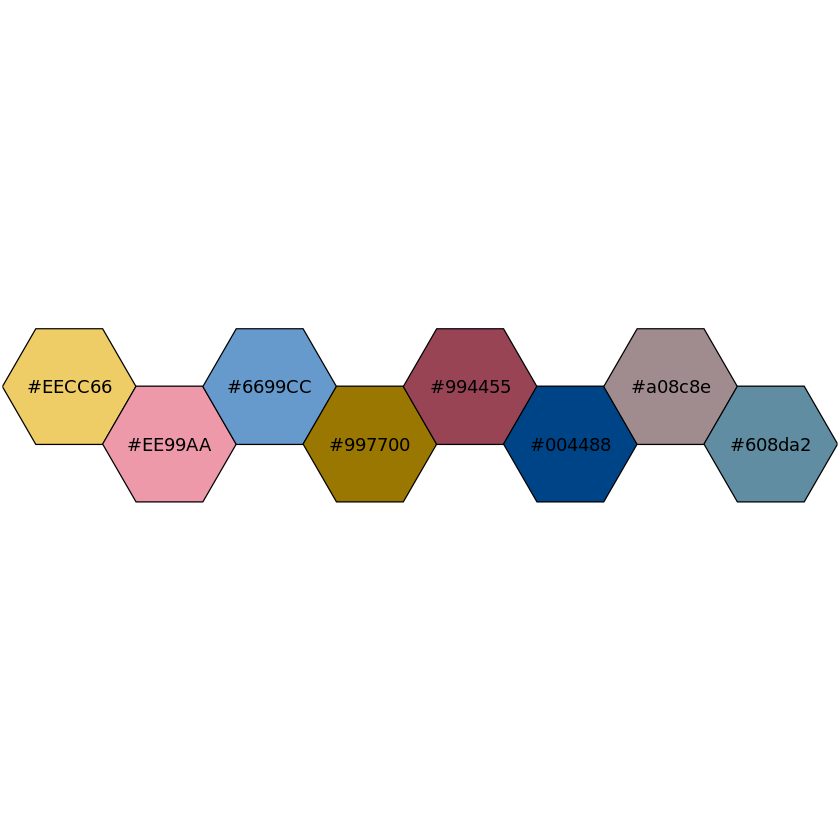

In [3]:
f_func <- "../functions.ipynb"
eval(parse(text = system2('jupyter', c('nbconvert', f_func, '--to=script', '--stdout'), stdout = TRUE)))
f_path <- "../dirs.ipynb"
eval(parse(text = system2('jupyter', c('nbconvert', f_path, '--to=script', '--stdout'), stdout = TRUE)))
f_cols <- "../cols.ipynb"
eval(parse(text = system2('jupyter', c('nbconvert', f_cols, '--to=script', '--stdout'), stdout = TRUE)))

In [4]:
sample_nm <- c()
step_nm <- c()
for (file in list.files(SPL_STATS_DIR, pattern = "R1")){
    sample_nm <- c(sample_nm, unlist(strsplit(file, '_'))[1])
    step_nm <- c(step_nm, paste0(unlist(strsplit(file, '_'))[3], unlist(strsplit(file, '_'))[4]))
}
mt <- matrix(ncol = length(unique(sample_nm)), nrow = length(unique(step_nm)))
colnames(mt) <- unique(sample_nm)
rownames(mt) <- unique(step_nm)
for (file in list.files(SPL_STATS_DIR)){
    sample <- unlist(strsplit(file, '_'))[1]
    step <- paste0(unlist(strsplit(file, '_'))[3], unlist(strsplit(file, '_'))[4])
    line_count <- read.csv(file = paste0(SPL_STATS_DIR,file), header=FALSE, sep = "\t", stringsAsFactors=FALSE)
    mt[step, sample] <- line_count[1,1]
}

In [5]:
nm_oi <- list_oi <- c("Archaea", "Bacteria", "Fungi", "Viruses", "Homo sapiens")
mt_t <- matrix(ncol = 7, nrow = length(nm_oi))
colnames(mt_t) <- c("sample", "taxa", "db", "conf",
                    "percentage", "count", "minimizers_est")
rownames(mt_t) <- nm_oi

if(exists("build_df")){rm("build_df")}
for (file in list.files(SPL_K2_REP, recursive = TRUE, pattern = paste0("*.report"))){
    if(grepl(file, pattern = "_RS")){
        mt_tmp <- mt_t
        smpl <- gsub(file, pattern = "_.*", replacement = "")
        mt_tmp[,"sample"] <- gsub(file, pattern = "_.*", replacement = "")
        mt_tmp[,"conf"] <- gsub(gsub(gsub(file, pattern = ".report", replacement = ""), 
                                               pattern = ".*_", replacement = ""), 
                                               pattern = "conf", replacement = "")
        smpl_db <- gsub(gsub(file, pattern = "_conf.*", replacement = ""), pattern = ".*/", replacement = "")
        
        if(grepl(file, pattern = "_RS_conf")){mt_tmp[,"db"] <- "RS"}
        if(grepl(file, pattern = "_RS_minusT2T_conf")){mt_tmp[,"db"] <- "RS w/o CHM13v2"}                                          

        k2prep <- read.csv(paste0(SPL_K2_REP, file), header=FALSE, sep = "\t", stringsAsFactors=FALSE)
        k2prep$V8 <- str_trim(k2prep$V8, side = "left")
        for (i in nm_oi){
            mt_tmp[i,"taxa"] <- i
            mt_tmp[i,"count"] <- as.numeric(k2prep$V2[which(k2prep$V8 == i)])
            mt_tmp[i,"minimizers_est"] <- as.numeric(k2prep$V5[which(k2prep$V8 == i)])
        }

        QC_rc <- mt["04adapt", smpl]
        mt_tmp[,"percentage"] <- as.numeric(mt_tmp[,"count"])/QC_rc*10^6

        if(!exists("build_df")){build_df <- mt_tmp} else {build_df <- rbind(build_df, mt_tmp)}
    }
}

In [6]:
k2_build_data <- data.frame(build_df) %>% 
    mutate(sample_short = str_replace(sample, str_sub(sample, 1, 3), "")) %>%
    filter(sample_short %in% c("Bctrl", "Pctrl")) %>% 
    mutate(sample_short = ifelse(sample_short == "Bctrl", yes = "BAL fluid, control", no = sample_short))  %>% 
    mutate(sample_short = ifelse(sample_short == "Pctrl", yes = "plasma, control", no = sample_short))  %>% 
    filter(!grepl(sample, pattern = "[A-Z]$")) %>% 
    filter(grepl(sample, pattern = "^H")) %>%  
    filter(sample %nin% c("H02Bctrl", "H23Bctrl"))  %>% 
    mutate(percentage = as.numeric(percentage)) %>%
    mutate(minimizers_est = as.numeric(minimizers_est)) %>% 
    mutate(count = as.numeric(count))  %>% 
    mutate(taxa = factor(taxa, levels = c("Homo sapiens", "Archaea", "Bacteria", "Fungi", "Viruses")))

In [7]:
k2_build_norm <- k2_build_data
for (i in 1:nrow(k2_build_data)){
    k2_build_norm[i,c("percentage", "count", "minimizers_est")] = 
        as.numeric(k2_build_norm[i,c("percentage", "count", "minimizers_est")])/ 
            as.numeric(k2_build_norm[which(k2_build_norm$sample == k2_build_norm$sample[i] &
            k2_build_norm$taxa == k2_build_norm$taxa[i] & 
            k2_build_norm$conf == k2_build_norm$conf[i] & 
            grepl(k2_build_norm$db, pattern = "RS w/o CHM13v2")),c("percentage", "count", "minimizers_est")]) 
}
options(repr.plot.width=7, repr.plot.height=7)
plt_hs_norm <- k2_build_norm %>% 
    filter(db == "RS") %>% 
    filter(taxa == "Homo sapiens") %>% 
    mutate(taxa = paste0(taxa, " (S)")) %>% 
    ggplot() + 
        geom_line(aes(x = conf, y = count, group = sample, col = sample_short), 
                  linewidth = 1, alpha = 0.3) + theme_bw() + 
        geom_line(data = k2_build_norm %>% 
                                filter(db == "RS") %>% 
                                filter(taxa == "Homo sapiens") %>% 
                                mutate(taxa = paste0(taxa, " (S)")) %>% 
                                group_by(conf, taxa) %>% 
                                summarise(avg_count = mean(count, na.rm = TRUE), .groups = "keep"), 
                  aes(x = conf, y = avg_count, group = taxa), col = "grey28", linewidth = 1.4, linetype = "dotted") +
        ylim(0.98,1.2) + labs(color = "") + 
        ylab("normalized host read counts\nuR.7 : uR.7 w/o CHM13v2") + xlab("Confidence Threshold") +
        scale_color_manual(values=alpha(c(as.character(colors_mc[c(5,6)])), 0.6)) + 
        theme_bw() + theme(legend.position = c(0.95, 0.25),
            legend.justification = c("right", "top"),
            legend.box.just = "right",
            legend.margin = margin(6, 6, 6, 6)
        )

In [8]:
file_list <- list.files(pattern = "_RS_conf", path = SPL_K2_OUT)

report_RS = read.delim(file = list.files(path = SPL_K2_REP, 
                                         pattern = "RS_conf", full.names = TRUE)[1], 
                                         header = FALSE)
txd_nm_RS <- report_RS[, c(ncol(report_RS)-2):ncol(report_RS)]
colnames(txd_nm_RS) <- c("taxLvl", "taxID", "name")
txd_nm_RS <- txd_nm_RS %>% mutate(name = str_trim(name, side = "left"))

if(exists("read_tracing")){rm("read_tracing")}
for (f in file_list){
    if(grepl(f, pattern = "^H") & f %nin% c("H02Bctrl", "H23Bctrl")){
        tmp_out_RS <- read.delim(
            file = paste0(SPL_K2_OUT, f), sep = "\t", header = FALSE)
        tmp_out_RS_minusT2T <- read.delim(
            file = paste0(SPL_K2_OUT, gsub(f, pattern = "RS", replacement = "RS_minusT2T")), 
            sep = "\t", header = FALSE)
        rn_hm <- tmp_out_RS %>% dplyr::rename(taxID = "V3") %>% filter(taxID == "9606") %>% select("V2")
        
        add_to_tracing  <- tmp_out_RS_minusT2T %>% 
            filter(V2 %in% unlist(rn_hm)) %>% 
            dplyr::rename(taxID = "V3") %>% 
            select("taxID") %>% mutate(name = f) %>% 
            group_by(name, taxID) %>% 
            summarise(n=n(), .groups = "keep") %>% 
            mutate(taxID = as.factor(taxID)) %>% 
            mutate(taxa = sapply(taxID, function(x) paste0(
                str_trim(txd_nm_RS$name[txd_nm_RS$taxID == x], side = "left"), " (", 
                txd_nm_RS$taxLvl[txd_nm_RS$taxID == x], ")"))) %>% 
            mutate(taxa_lvl = sapply(taxID, function(x) txd_nm_RS$taxLvl[txd_nm_RS$taxID == x]))
        add_to_tracing[,"QC_rc"] <- mt["04adapt",gsub(f, pattern = "_.*", replacement = "")]
        if(exists("read_tracing")){read_tracing <- rbind(read_tracing, add_to_tracing)}
        else{read_tracing <- add_to_tracing}
    }
}
for (i in 1:nrow(read_tracing)){
    index_micr <- which(txd_nm_RS$name %in% c("unclassified", "root", "other entries",
                                              "Eukaryota", "Bacteria", "Viruses", "Fungi", "Sar", "Archaea"))
    names(index_micr) <- txd_nm_RS$name [index_micr]
    
    index <- which(txd_nm_RS$taxID == c(read_tracing$taxID[i]))
    read_tracing[i,"domain"] = names(which(index_micr <= index)[max(which(index_micr <= index))])
}

In [9]:
plt_hs <- read_tracing %>% 
    mutate(n_norm = n/QC_rc) %>% 
    filter(taxID == "9606") %>% 
    mutate(sample = gsub(name, pattern = "_.*", replacement = "")) %>% 
    mutate(conf = gsub(gsub(name, pattern = ".output_classified", replacement = ""), 
                       pattern = ".*conf", replacement = "")) %>% 
    group_by(taxa, taxID, taxa_lvl, conf, domain) %>% 
    summarise(mean_n_norm = mean(n_norm), sd_n_norm = sd(n_norm, na.rm = TRUE), .groups = "keep") %>% 
    mutate(taxa_lvl_short = substr(taxa_lvl, 1, 1)) %>%
    ggplot() +
        geom_bar(aes(x=conf, y=mean_n_norm), position="stack", stat="identity", col = "lightgrey", alpha = 1) + 
        geom_errorbar(aes(x=conf, ymin=mean_n_norm, ymax=mean_n_norm+sd_n_norm), width=0.4, col = "lightgrey", alpha = 1, size=1.3) + 
        theme_bw() + theme(legend.position = c(0.95, 0.98),
            legend.justification = c("right", "top"),
            legend.box.just = "right",
            legend.margin = margin(6, 6, 6, 6)) +
        ylab("% reads") + xlab("Confidence Threshold") +  
        labs(fill="")

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


In [10]:
stat.test_build <- k2_build_norm %>% 
    filter(taxa %nin% c("Fungi", "Homo sapiens")) %>%
    filter(conf == gsub(fav_threshold, pattern = "conf", replacement = "")) %>% 
    mutate(db = factor(db, levels = c("RS w/o CHM13v2", "RS"))) %>% 
    group_by(taxa) %>% 
        t_test(percentage ~ db, paired = TRUE, 
            p.adjust.method="bonferroni", 
            var.equal = sample, 
            alternative = "less")  %>% 
    mutate(p = ifelse(is.na(p), "#", p)) %>% 
    mutate(p = paste0("\n\n\n",p))

micr_violin <- k2_build_norm %>% 
    filter(taxa %nin% c("Fungi", "Homo sapiens")) %>%
    filter(conf == gsub(fav_threshold, pattern = "conf", replacement = "")) %>% 
    mutate(db = factor(db, levels = c("RS w/o CHM13v2", "RS"))) %>% 
    ggplot() + 
        geom_dotplot(aes(fill = sample_short, x = db, y = percentage), col = NA, width = 0.6, binaxis = "y", stackdir = "center", dotsize = 1.5) + 
        geom_violin(aes(x = db, y = percentage), col = colors_mc[1], fill = NA, width = 0.4, size = 1.5) + 
        theme_bw() + 
        theme(panel.spacing.y = unit(2, "lines"), 
                            plot.title = element_text(hjust = 0.5, face = "bold"), 
                            plot.subtitle = element_text(hjust = 0.5), 
                            strip.background = element_blank()) + 
        labs(x = "", y = "RPM, normalized", fill = "") + 
        scale_fill_manual(values=alpha(c(as.character(colors_mc[c(5,6)])), 0.6)) + 
        scale_color_manual(values=alpha(c(as.character(colors_mc[c(1)])), 0.6)) + 
        stat_pvalue_manual(size = 5, stat.test_build, 
                           label = "p", y.position = 1.1) +
        facet_grid(rows = vars(taxa)) +
        geom_hline(yintercept = 1.05) + 
        geom_text(size = 5,  
            data = k2_build_data %>% 
                        filter(taxa %nin% c("Fungi", "Homo sapiens")) %>%
                        filter(conf == gsub(fav_threshold, pattern = "conf", replacement = "")) %>% 
                        mutate(db = factor(db, levels = c("RS w/o CHM13v2", "RS"))) %>% 
                        group_by(taxa, db) %>% 
                    summarise(meanY = round(mean(percentage), digits = 2), 
                        labY = paste0("mu=", round(mean(percentage), digits = 2)), .groups="keep"),
            aes(x = db, y = 1.075, label = labY)) +  
        scale_y_continuous(breaks = seq(0.9,1,0.05), limits = c(0.9,1.125), labels = seq(0.9,1,0.05)) +
    theme_bw() + 
    scale_x_discrete(labels=c(
                            "RS w/o CHM13v2" = "uR.7 w/o\nCHM13v2", "RS" = "uR.7 ", 
                            "EPRSc2" = "cRE.21", "EPRSFv46DM" = "dRE.21", "EPRSFv46MCAspDM" = "dREM.258", 
                            "EPRSFv64DM" = "dRE.31", "EPRSFv64MCAspDM" = "dREM.260"))   

In [11]:
stat.test_build_0.8 <- k2_build_norm %>% 
    filter(taxa %nin% c("Homo sapiens")) %>%
    filter(conf == "0.8") %>% 
    mutate(db = factor(db, levels = c("RS w/o CHM13v2", "RS"))) %>% 
    group_by(taxa) %>% 
        t_test(percentage ~ db, paired = TRUE, 
            p.adjust.method="bonferroni", 
            var.equal = sample, 
            alternative = "less")  %>% 
    mutate(p = ifelse(is.na(p), "#", p)) %>% 
    mutate(p = paste0("\n\n\n",p))

micr_violin_0.8 <- k2_build_norm %>% 
    filter(taxa %nin% c("Homo sapiens")) %>%
    filter(conf == "0.8") %>% 
    mutate(db = factor(db, levels = c("RS w/o CHM13v2", "RS"))) %>% 
    ggplot() + 
        geom_dotplot(aes(fill = sample_short, x = db, y = percentage), col = NA, width = 0.6, binaxis = "y", stackdir = "center", dotsize = 1.5) + 
        geom_violin(aes(x = db, y = percentage), col = colors_mc[1], fill = NA, width = 0.4, size = 1.5) + 
        theme_bw() + 
        theme(panel.spacing.y = unit(2, "lines"), 
                            plot.title = element_text(hjust = 0.5, face = "bold"), 
                            plot.subtitle = element_text(hjust = 0.5), 
                            strip.background = element_blank()) + 
        labs(x = "", y = "RPM, normalized", fill = "") + 
        scale_fill_manual(values=alpha(c(as.character(colors_mc[c(5,6)])), 0.6)) + 
        scale_color_manual(values=alpha(c(as.character(colors_mc[c(1)])), 0.6)) + 
        stat_pvalue_manual(size = 5, stat.test_build_0.8, 
                           label = "p", y.position = 1.1) +
        facet_grid(rows = vars(taxa)) +
        geom_hline(yintercept = 1.05) + 
        geom_text(size = 5,  
            data = k2_build_data %>% 
                        filter(taxa %nin% c("Homo sapiens")) %>%
                        filter(conf == "0.8") %>% 
                        mutate(db = factor(db, levels = c("RS w/o CHM13v2", "RS"))) %>% 
                        group_by(taxa, db) %>% 
                    summarise(meanY = round(mean(percentage), digits = 2), 
                        labY = paste0("mu=", round(mean(percentage), digits = 2)), .groups="keep"),
            aes(x = db, y = 1.075, label = labY)) +  
        scale_y_continuous(breaks = seq(0.9,1,0.05), limits = c(0.9,1.125), labels = seq(0.9,1,0.05)) +
    theme_bw() + 
    scale_x_discrete(labels=c(
                            "RS w/o CHM13v2" = "uR.7 w/o\nCHM13v2", "RS" = "uR.7 ", 
                            "EPRSc2" = "cRE.21", "EPRSFv46DM" = "dRE.21", "EPRSFv46MCAspDM" = "dREM.258", 
                            "EPRSFv64DM" = "dRE.31", "EPRSFv64MCAspDM" = "dREM.260"))   

In [12]:
k2_build_norm <- k2_build_data
for (i in 1:nrow(k2_build_data)){
    k2_build_norm[i,c("percentage", "count", "minimizers_est")] = 
        as.numeric(k2_build_norm[i,c("percentage", "count", "minimizers_est")])/ 
            as.numeric(k2_build_norm[which(k2_build_norm$sample == k2_build_norm$sample[i] &
            k2_build_norm$taxa == k2_build_norm$taxa[i] & 
            k2_build_norm$conf == k2_build_norm$conf[i] & 
            k2_build_norm$db == "RS w/o CHM13v2"), c("percentage", "count", "minimizers_est")]) 
}

stat.class_norm_0.8 <- k2_build_norm %>% 
    filter(conf == "0.8") %>% 
    filter(taxa == "Homo sapiens") %>% 
    mutate(taxa = paste0(taxa, " (S)")) %>%
    mutate(db = factor(db, levels = c("RS","RS w/o CHM13v2"))) %>% 
    t_test(percentage ~ db, paired = TRUE, 
                             p.adjust.method="bonferroni", 
                             var.equal = sample, 
                             alternative = "greater")

host_class_norm_0.8 <- k2_build_norm %>% 
    filter(conf == "0.8") %>% 
    filter(taxa == "Homo sapiens") %>% 
    mutate(taxa = paste0(taxa, " (S)")) %>%
    mutate(db = factor(db, levels = c("RS w/o CHM13v2","RS"))) %>% 
    ggplot(aes(x = db, y = percentage)) + 
        geom_dotplot(aes(fill = sample_short), col = NA, width = 0.6, binaxis = "y", stackdir = "center", dotsize = 1.5) + 
        geom_violin(width = 0.4, col = colors_mc[1], fill = NA, size = 1.5) + 
        scale_fill_manual(values=alpha(c(as.character(colors_mc[c(5,6)])), 0.6)) +
        stat_pvalue_manual(size = 5, stat.class_norm_0.8, label = "p", y.position = c(1.15)) + 
        theme_bw() + labs(y = "RPM, normalized", col = "", x = "") + ylim (1,1.175) +
        guides(color = FALSE, fill = FALSE) + 
        scale_x_discrete(labels=c(
                                "RS w/o CHM13v2" = "uR.7 w/o\nCHM13v2", "RS" = "uR.7 ", 
                                "EPRSc2" = "cRE.21", "EPRSFv46DM" = "dRE.21", "EPRSFv46MCAspDM" = "dREM.258", 
                                "EPRSFv64DM" = "dRE.31", "EPRSFv64MCAspDM" = "dREM.260")) 
#host_class_norm_0.8

Warning message:
“The `<scale>` argument of `guides()` cannot be `FALSE`. Use "none" instead as of ggplot2 3.3.4.”


Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.
Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.
Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.
Warning message:
“Removed 2 rows containing missing values (`stat_bindot()`).”
Warning message:
“Removed 2 rows containing non-finite values (`stat_ydensity()`).”
Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.
Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.
Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.
Warning message:
“Removed 2 rows containing missing values (`stat_bindot()`).”
Warning message:
“Removed 2 rows containing non-finite values (`stat_ydensity()`).”
Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.
Bin width defaults to 1/30 of the range of the data. Pick 

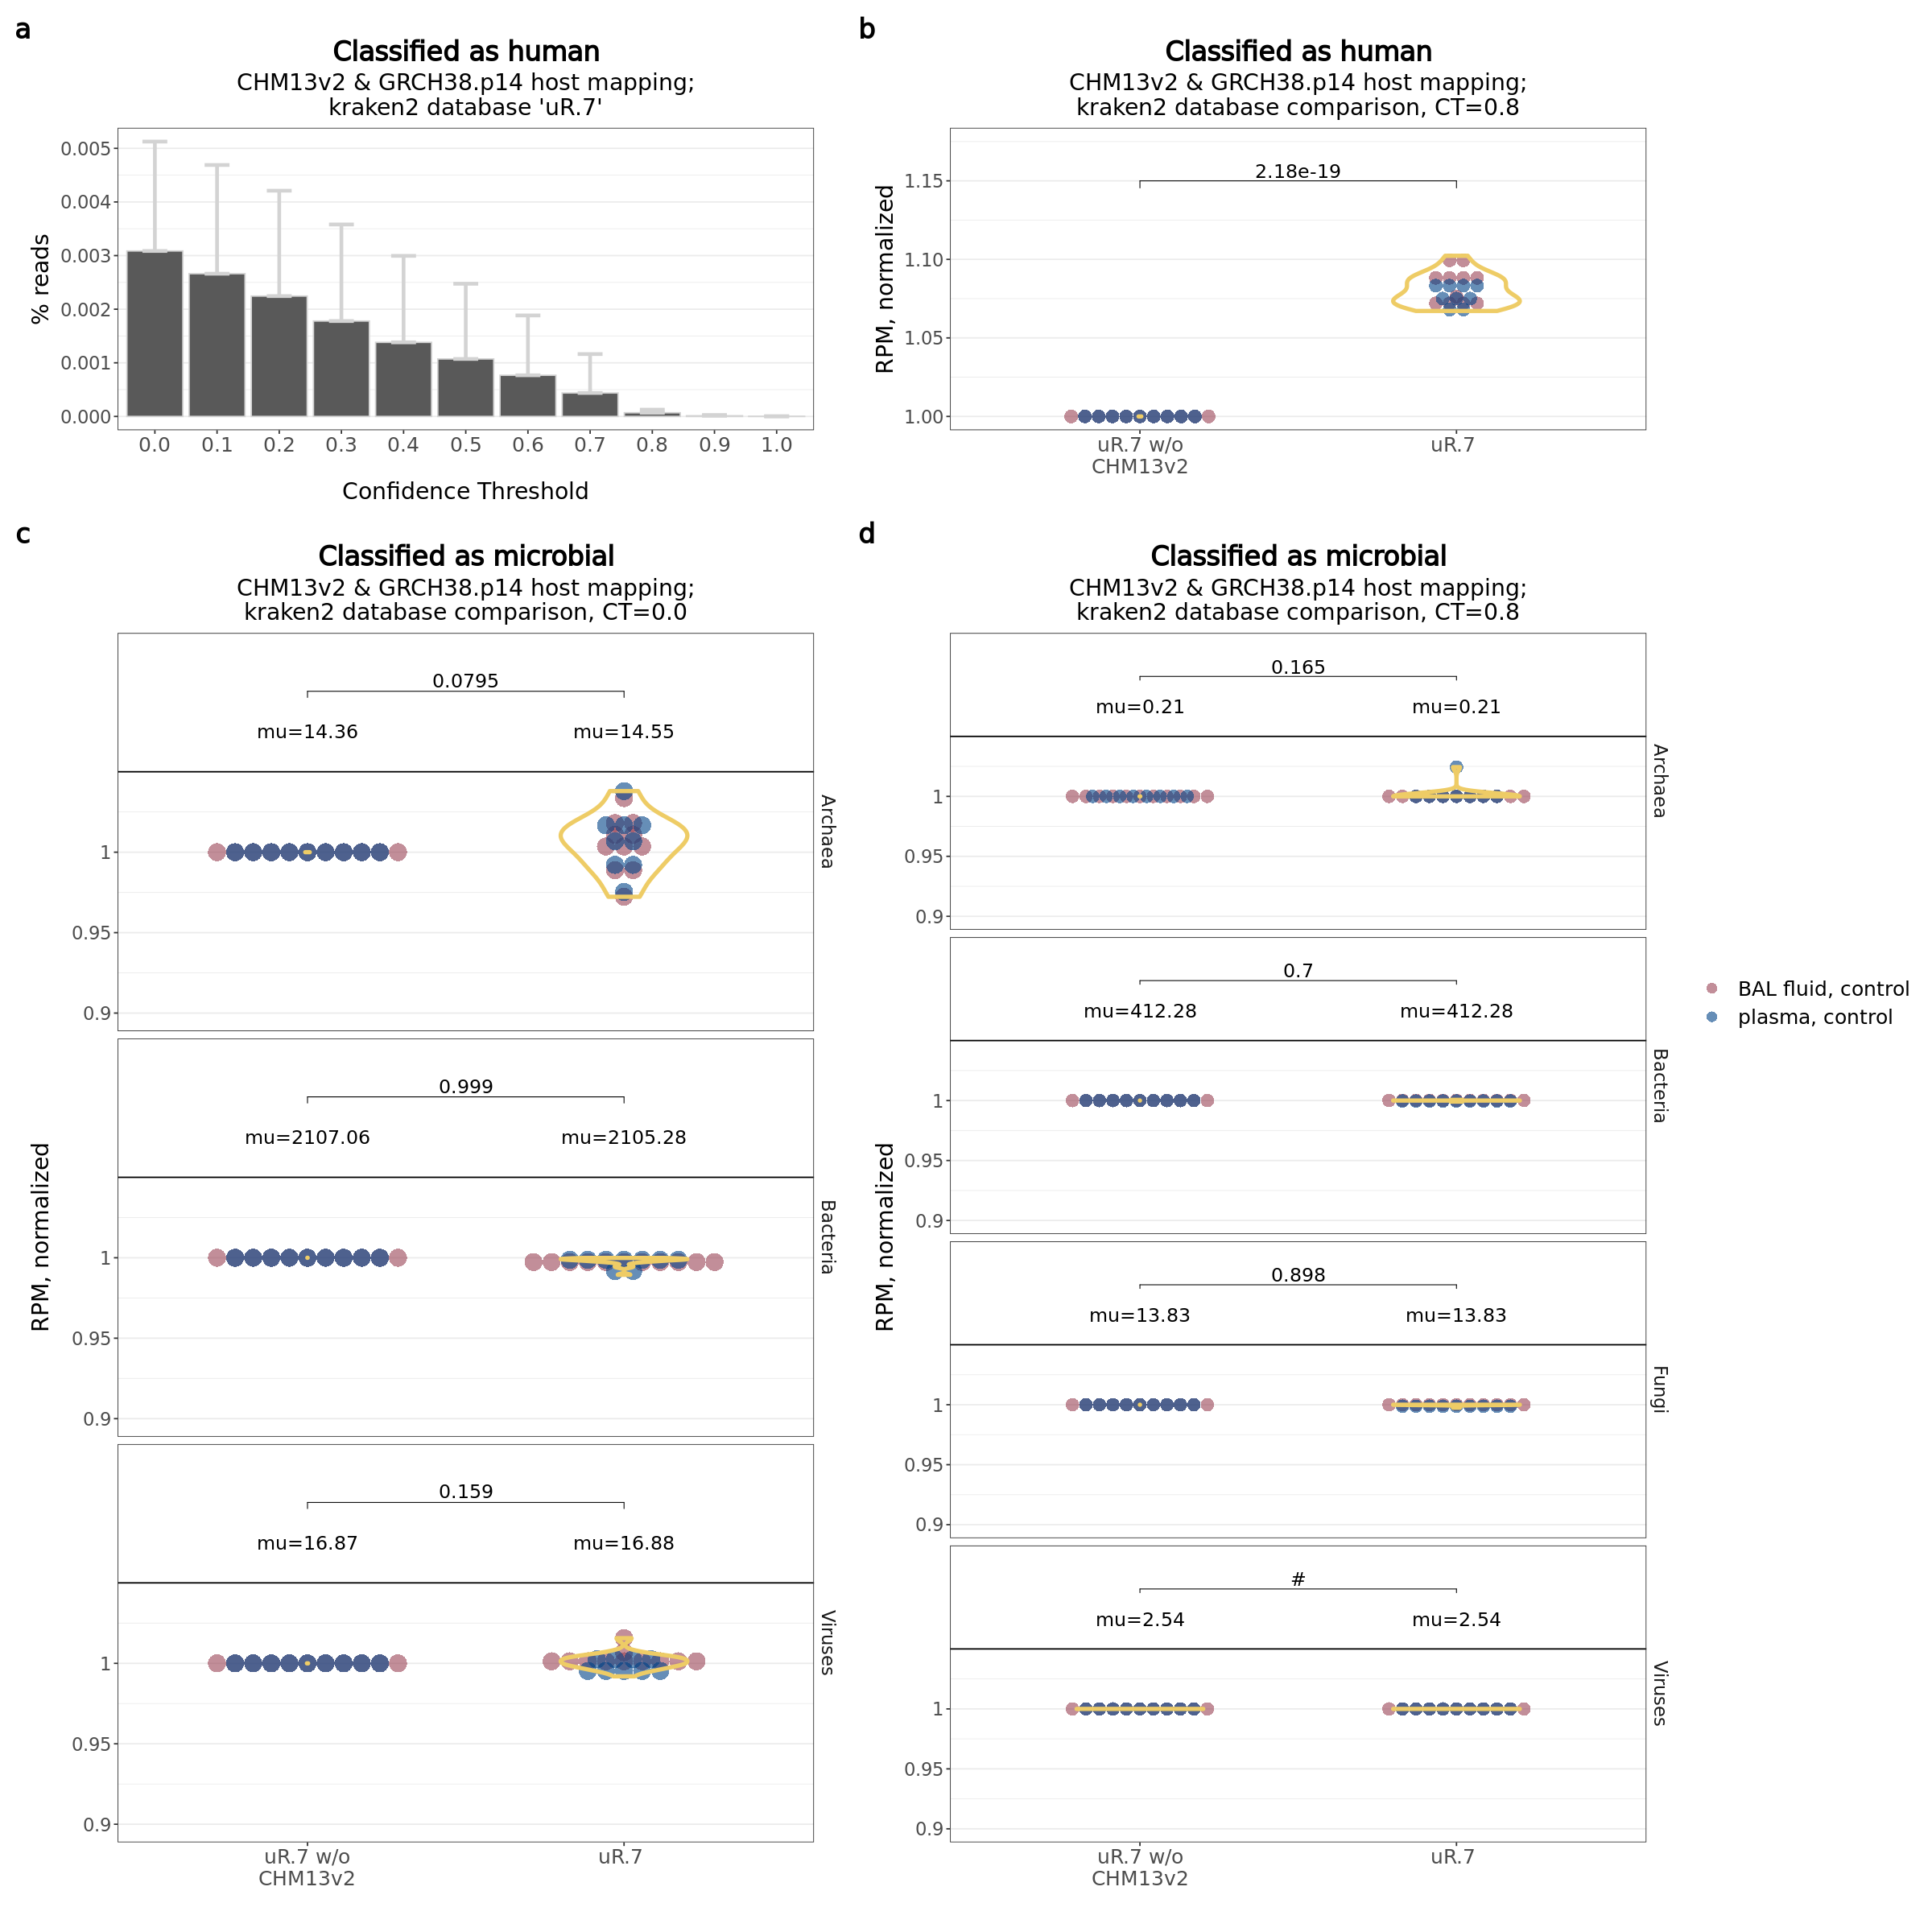

In [13]:
options(repr.plot.width=20, repr.plot.height=20)
SuplFig3 <- 
    (plt_hs + ggtitle("Classified as human", subtitle = "CHM13v2 & GRCH38.p14 host mapping;\nkraken2 database 'uR.7'")) + 
    (host_class_norm_0.8 +  ggtitle("Classified as human", subtitle = "CHM13v2 & GRCH38.p14 host mapping;\nkraken2 database comparison, CT=0.8")) + 
    (micr_violin + guides(fill = "none") +  ggtitle("Classified as microbial", subtitle = "CHM13v2 & GRCH38.p14 host mapping;\nkraken2 database comparison, CT=0.0")) + 
    (micr_violin_0.8 +  ggtitle("Classified as microbial", subtitle = "CHM13v2 & GRCH38.p14 host mapping;\nkraken2 database comparison, CT=0.8")) +
        plot_layout(heights = c(1,4), ncol = 2, guides = "collect") &
        plot_annotation(tag_levels = 'a') &
        theme(legend.position='right', legend.justification='right', legend.direction = 'vertical', 
            axis.text.x = element_text(size = 15), 
            legend.key.size = unit(0.75, 'cm'), legend.key.height = unit(0.75, 'cm'), legend.key.width = unit(0.75, 'cm'), 
            text = element_text(size = 17), 
            legend.title = element_text(size = 18), legend.text = element_text(size = 15, colour = "black"),
            plot.title = element_text(size = 20, hjust = 0.5, face = "bold"), 
            plot.subtitle = element_text(size = 17, hjust = 0.5), 
            plot.tag = element_text(face = 'bold', size = 20), 
            strip.background = element_blank(),
            panel.grid.major.x = element_blank(),
            panel.grid.minor.x = element_blank())

SuplFig3

ggsave("../../output/suppl_figures/SuplFig3_R.png", 
       SuplFig3, width = 20, height = 20)
ggsave("../../output/suppl_figures/SuplFig3_R.pdf", 
       SuplFig3, width = 20, height = 20)